In [1]:
import time
from typing import Optional, Tuple, List

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader

In [2]:
torch.cuda.is_available()

True

In [3]:
torch.__version__

'2.0.1+cu118'

In [4]:
from torchvision import datasets
from torchvision.transforms import ToTensor

train_data = datasets.MNIST(
    root='../models/mnist',
    train=True,
    transform=ToTensor(),
    download=True,
)

test_data = datasets.MNIST(
    root='../models/mnist',
    train=False,
    transform=ToTensor(),
    download=True,
)

In [5]:
class TrainHelper:
    @staticmethod
    def train(cnn: nn.Module,
              *,
              epochs: int,
              train_dataset: datasets.MNIST,
              test_dataset: Optional[datasets.MNIST] = None,
              print_results: bool = True,
              print_each_step: bool = False,
              batch_size: int,
              lr: float) -> List[float]:

        train_loader = torch.utils.data.DataLoader(train_dataset,
                                                   batch_size=batch_size,
                                                   shuffle=True,
                                                   num_workers=1)

        device = torch.device('cuda')

        cnn.to(device)
        cnn.train()

        optimizer = torch.optim.Adam(cnn.parameters(), lr=lr)
        loss_func = nn.CrossEntropyLoss()

        eval_results: List[float] = []

        for epoch in range(epochs):
            for images, labels in train_loader:
                images = Variable(images.to(device))
                labels = Variable(labels.to(device))

                output = cnn(images)
                loss = loss_func(output, labels)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                if print_each_step:
                    print(f"step, loss = {loss.item()}")

            if test_dataset is not None:
                eval_result = TrainHelper.test(cnn, test_dataset, device)
                eval_results.append(eval_result)
                if print_results:
                    print(f"epoch {epoch}, accuracy = {eval_result}, loss = {loss.detach()}")
                cnn.train()

        optimizer.zero_grad(set_to_none=True)

        return eval_results

    @staticmethod
    def test(cnn: nn.Module, test_dataset: datasets.MNIST, device=None) -> float:
        cnn.eval()
        loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=1)
        correct = 0
        incorrect = 0

        with torch.no_grad():
            for images, labels in loader:
                if device is not None:
                    images = images.to(device)

                results = cnn(images)
                predictions = results.detach().cpu().numpy().argmax(axis=1)
                oks = (predictions == labels.numpy()).sum()
                correct += oks
                incorrect += len(predictions) - oks

        return correct / (correct + incorrect)

    @staticmethod
    def train_models(models: List[nn.Module], *, batch_size: int = 256, train_plan: List[Tuple[float, int]]) -> Tuple[int, float]:
        assert len(models) > 0

        for model in models:
            start = time.time()
            for lr, epochs in train_plan:
                eval_results = TrainHelper.train(
                    cnn=model,
                    epochs=epochs,
                    train_dataset=train_data,
                    test_dataset=test_data,
                    batch_size=batch_size,
                    print_results=False,
                    lr=lr,
                )
            end = time.time()
            best_acc = max(eval_results)
            params_count = TrainHelper.total_parameters_count(model)
            print(f"best accuracy = {best_acc}, parameters = {params_count}, training time = {end - start}")
            yield params_count, best_acc

    @staticmethod
    def total_parameters_count(model: nn.Module) -> int:
        return sum(np.prod(p.size()) for p in model.parameters())

    @staticmethod
    def print_parameters(model: nn.Module):
        print(f"total parameters = {TrainHelper.total_parameters_count(model)}")
        for p in model.parameters():
            print(f"size {np.prod(p.size())}: {p.size()}")

In [6]:
class PixelNorm2d(nn.Module):
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return x * (x.pow(2).mean(dim=1, keepdim=True) + 1e-8).rsqrt()


class Residual(nn.Module):
    def __init__(self, layer: nn.Module):
        super().__init__()
        self.layer = layer

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return x + self.layer(x)


class RotEmbedding2d(nn.Module):
    def __init__(self, *, base: float = 10000.0, heads: int):
        super().__init__()
        self.base: float = base
        self.heads: int = heads

    def forward(self, keys: torch.Tensor) -> torch.Tensor:
        b, c, h, w = keys.shape
        device = keys.device

        k = torch.reshape(keys, (b * self.heads, c // self.heads, h, w))

        indices_x = torch.reshape(torch.arange(w, device=device, dtype=torch.float32), (1, 1, 1, w))
        indices_y = torch.reshape(torch.arange(h, device=device, dtype=torch.float32), (1, 1, h, 1))
        
        indices_ch = torch.arange(c // self.heads // 4, device=device, dtype=torch.float32)
        angles = torch.reshape(self.base ** (indices_ch / -indices_ch.size(0)), (1, -1, 1, 1))
        # angles starting from self.base ** 0 and end with self.base ** -1 

        angles_x = angles * indices_x
        angles_y = angles * indices_y

        sin_x, cos_x = angles_x.sin(), angles_x.cos()
        sin_y, cos_y = angles_y.sin(), angles_y.cos()

        s = k.size(1) // 4
        k0, k1, k2, k3 = k[:, :s], k[:, s:2 * s], k[:, 2 * s:3 * s], k[:, 3 * s:],
        rot_x = torch.cat([
            k0 * cos_x + k1 * sin_x,
            k1 * cos_x - k0 * sin_x,
            k2 * cos_y + k3 * sin_y,
            k3 * cos_y - k2 * sin_y,
        ], dim=1)

        return torch.reshape(rot_x, (b, -1, h, w))


class SelfAttention(nn.Module):
    def __init__(self, ch_in: int = 64, ch_keys: int = 64, *, heads: int, size: int):
        super().__init__()
        self.size = size
        self.heads = heads
        self.ch = ch_in
        self.ch_keys = ch_keys
        self.kqvh: nn.Conv2d = nn.Conv2d(ch_in, (ch_keys * 2 + ch_in) * heads, kernel_size=1, bias=True)
        self.rot_embed: RotEmbedding2d = RotEmbedding2d(heads=self.heads)

    def att(self, keys: torch.Tensor, queries: torch.Tensor, values: torch.Tensor, heads: int) -> torch.Tensor:
        b, c, h, w = keys.size()
        k = torch.reshape(keys, (b * heads, c // heads, h * w))
        q = torch.reshape(queries, (b * heads, c // heads, h * w))

        r = torch.bmm(torch.moveaxis(k, 1, 2), q)
        r = torch.softmax(r / self.size, dim=1)

        v = torch.reshape(values, (b * heads, -1, self.size * self.size))

        v = torch.bmm(v, r)
        v = torch.reshape(v, (b, heads, -1, self.size, self.size))
        v = torch.sum(v, dim=1)
        return v

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x_kqvh = self.kqvh(x)
        s = self.ch_keys * self.heads
        x_kh = x_kqvh[:, :s]
        x_qh = x_kqvh[:, s: s * 2]
        x_vh = x_kqvh[:, s * 2:]

        return self.att(self.rot_embed(x_kh), self.rot_embed(x_qh), x_vh, self.heads)


class MyTransformerModel(nn.Module):
    def __init__(self, ch: int = 64, k_ch: int = 64, heads: int = 4, layers_count: int = 8, conv_ch: int = 64):
        super().__init__()

        lst = [
            nn.Conv2d(1, 32, kernel_size=5, padding='same', bias=True),
            nn.LeakyReLU(0.1),
            nn.Conv2d(32, ch, kernel_size=3, padding='same', bias=True),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2),
        ]

        for i in range(layers_count):
            lst += [
                Residual(SelfAttention(ch, k_ch, heads=heads, size=14)),
                PixelNorm2d(),
                Residual(nn.Sequential(
                    nn.Conv2d(ch, conv_ch, kernel_size=1, bias=True),
                    nn.LeakyReLU(),
                    nn.Conv2d(conv_ch, ch, kernel_size=1, bias=True),
                )),
                PixelNorm2d(),
            ]

        lst += [
            nn.AvgPool2d((14, 14)),
            nn.Conv2d(ch, 10, kernel_size=1, bias=True),
            nn.Flatten(),
        ]

        self.layers = nn.Sequential(*lst)

    def forward(self, x: torch.Tensor):
        return self.layers(x)

In [7]:
results = []
for i in range(4):
    models = [
        MyTransformerModel(ch=32, k_ch=32, conv_ch=32, heads=4, layers_count=6),
        MyTransformerModel(ch=64, k_ch=32, conv_ch=32, heads=4, layers_count=6),
        MyTransformerModel(ch=64, k_ch=64, conv_ch=64, heads=4, layers_count=8),
    ]
    for pair in TrainHelper.train_models(models, batch_size=256, train_plan=[(0.001, 10), (0.0001, 30)]):
        results.append(pair)

/home/lgor/projects/2023/pyenv310torch/lib/python3.10/site-packages/torch/nn/modules/conv.py:459: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


best accuracy = 0.993, parameters = 99114, training time = 840.0435590744019
best accuracy = 0.9948, parameters = 244810, training time = 1157.5559334754944
best accuracy = 0.9947, parameters = 485898, training time = 1837.3037114143372
best accuracy = 0.9937, parameters = 99114, training time = 777.0265471935272
best accuracy = 0.9936, parameters = 244810, training time = 962.3140456676483
best accuracy = 0.9948, parameters = 485898, training time = 1913.9240610599518
best accuracy = 0.9929, parameters = 99114, training time = 872.8439481258392
best accuracy = 0.9942, parameters = 244810, training time = 961.6499147415161
best accuracy = 0.9942, parameters = 485898, training time = 1817.7613258361816
best accuracy = 0.9943, parameters = 99114, training time = 827.339804649353
best accuracy = 0.9936, parameters = 244810, training time = 941.313976764679
best accuracy = 0.995, parameters = 485898, training time = 1713.0082731246948


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


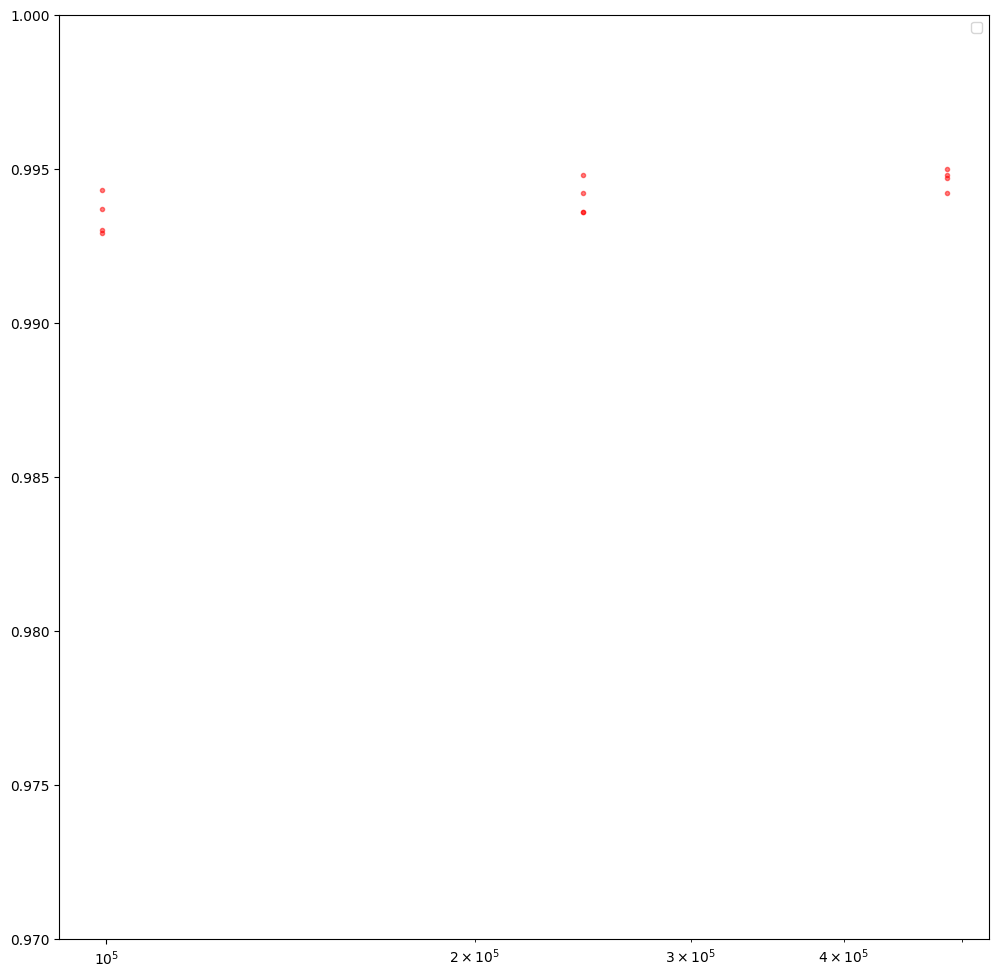

In [8]:
plt.rcParams['figure.figsize'] = [12, 12]
fig, ax = plt.subplots()
ax.set_xscale("log")
ax.set_ylim(0.97, 1)

params_counts = [p[0] for p in results]
accuracies = [p[1] for p in results]

ax.scatter(params_counts, accuracies, c='red', alpha=0.5, marker=r'.')

ax.legend()
plt.show()